# 나의 첫 번째 캐글 경진대회


### 학습목표


---

- 데이터 사이언스 관련 커뮤니티인 캐글의 경진대회에 잠여해서 문제를 해결
- 캐글에서 데이터를 받아서, 로컬 서버에서 자유롭게 다루어보며 문제해결을 위한 고민
- 앙상블 기법의 개념과 강점을 이해, 여러 모델의 예측 결과를 Averaging 한 최종 결과로 캐글에 제출
- 하이퍼 파라미터 튜닝의 필요성과 의미를 이해, Grid Search, Random Search 등의 기법을 알아봄
- Grid Search 기법을 이용해 하이퍼 파라미터 튜닝 실험과 모델의 성능을 최대화


### 얻을 수 있는 기술


---

- 정형 데이터를 활용해 EDA(탐색적 데이터 분석)와 간단한 분류, 회귀 문제 해결 가능
- numpy, pandas, matplotlib을 활용해 정형 데이터를 다룰 수 있음
- 정형 데이터를 활용해 다양한 모델 학습, 예측 결과를 도출하는 것까지 코드로 구현 가능


### 목차


---

1. 대회의 시작: 참가 규칙과 데이터, 평가 기준 살펴보기
2. Baseline
3. 최적화 모델을 찾기 위한 하이퍼 파라미터 튜닝
4. 프로젝트: This is tour playground! Leaderboard 정복


### 사용할 모듈
---
- scikit-learn
- 회귀 모델 구현: `xgboost`, `lightgbm` 라이브러리
- 결측 데이터 확인: `missingno` 라이브러리

## 1. 데이터 살펴보기

## Data Description, 데이터 설명
1. Data fields
2. ID : 집을 구분하는 번호
3. date : 집을 구매한 날짜
4. price : 집의 가격(Target variable)
5. bedrooms : 침실의 수
6. bathrooms : 화장실의 수
7. sqft_living : 주거 공간의 평방 피트(면적)
8. sqft_lot : 부지의 평방 피트(면적)
9. floors : 집의 층 수
10. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
11. view : 집이 얼마나 좋아 보이는지의 정도
12. condition : 집의 전반적인 상태
13. grade : King County grading 시스템 기준으로 매긴 집의 등급
14. sqft_above : 지하실을 제외한 평방 피트(면적)
15. sqft_basement : 지하실의 평방 피트(면적)
16. yr_built : 지어진 년도
17. yr_renovated : 집을 재건축한 년도
18. zipcode : 우편번호
19. lat : 위도
20. long : 경도
21. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
22. sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)


다양한 column이 있다. 예측해야 할 column은 `price`, 집의 가격이다.


## Data Explorer, 데이터 파일


- `train.csv` 모델 학습용 파일과, `test.csv` 테스트용 파일, `sample_submission.csv` 파일 제공
- `train.csv`를 활용해 데이터를 살펴보고 모델 학습
- `text.csv` 파일의 데이터에 대해 price를 예측해서
- `sample_submission.csv` 형식에 맞는 형태로 변경

## 2. Baseline 모델
### 2-1. Baseline 셋팅하기
- 캐글에서 제공하는 baseline.ipynb 파일을 받은 후 저장
- 회귀 모델을 구현하는데 필요한 라이브러리
  - conda install -c conda-forge xgboost=1.3.3
  - conda install -c conda-forge lightgbm=3.1.1 
  - conda install -c conda-forge missingno=0.4.2


In [1]:
import matplotlib.pyplot as plt
# notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것
%matplotlib inline 
# 그래프를 더 높은 해상도로 출력
%config InlineBackend.figure_format = 'retina' 

### 2-2. 라이브러리, 데이터 가져오기

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

**✓ 데이터 경로 지정하기**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
data_dir = '/content/gdrive/MyDrive/AIFFEL/kaggle-kakr-housing-data/data'
train_data_path = join(data_dir, 'train.csv') # -----(1)
sub_data_path = join(data_dir, 'test.csv') # -----(2)

print(train_data_path)
print(sub_data_path)

/content/gdrive/MyDrive/AIFFEL/kaggle-kakr-housing-data/data/train.csv
/content/gdrive/MyDrive/AIFFEL/kaggle-kakr-housing-data/data/test.csv


(1) train 시 사용할 데이터 경로   
(2) 테스트, 즉 submission 시 사용할 데이터 경로

### 2-3. 데이터 이해하기
여러가지 column 데이터 정보가 있다. 이러한 특징을 활용해서 집의 가격을 맞춰야 한다.

**✓ 데이터 불러오기**

In [5]:
data = pd.read_csv(train_data_path) # ----- (1)
sub = pd.read_csv(sub_data_path) # -----(2)

print(f"train data dim: {data.shape}")
print(data.info())

print(f"\nsub data dim:   {sub.shape}")
print(sub.info())

train data dim: (15035, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 n

(1) 불러온 데이터를 `data` 변수로 읽어온다.   
  - 학습 데이터는 15035개   

(2) 불러온 데이터를 `sub` 변수로 읽어온다.
  - 테스트 데이터는 6468개


**column 데이터에서 train data는 21개, sub data는 `price`를 맞춰야해서 20개로 1개가 적다**

**✓ 학습 데이터에서 라벨 제거하기**


`price`컬럼은 따로 `y`라는 변수에 저장한 후 해당 컬럼은 지운다.


- [w3schools - python del keyword](https://www.w3schools.com/python/ref_keyword_del.asp)
- 데이터 분석 과정에서 column을 없애고 싶다면 [pandas.DataFrame.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)도 사용가능하다.

In [6]:
y = data['price']
del data['price']
print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


**✓ 학습 데이터와 테스트 데이터 합치기**

- 모델을 학습하기 전, 전체 데이터에 대해 탐색해보기 위해 두 데이터를 `pd.concat`으로 합쳐보자.
- `train_len`에 `training data`의 개수를 저장하여 **학습데이터만 불러올 수 있는 인덱스로 사용**

In [7]:
train_len = len(data) # -----(1)
data = pd.concat((data, sub), axis=0) # -----(2)

print(train_len)

15035


(1) 학습데이터만 불러올 수 있게 인덱스로 저장   
(2) data, sub 데이터를 pd.concat()으로 병합
  - axis=0 은 행(row) 작업
  - axis=1 은 열(column) 작업

In [8]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


**✓ 간단한 전처리**   


~~알고 싶었던 작업인데 이렇게 사용하는 거구나...~~

- 빈 데이터와 전체 데이터의 분포를 확인하는 전처리 작업
- 결측치: 빈 데이터가 있는지 `missingno`라이브러리를 사용해서 확인   


> 각 변수들에 대해 결측 유무를 확인하고,   
분포를 확인해보면서 간단하게 전처리를 하겠습니다.   
먼저 데이터에 결측치가 있는지를 확인하겠습니다.   
missingno 라이브러리의 matrix 함수를 사용하면,    
데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.



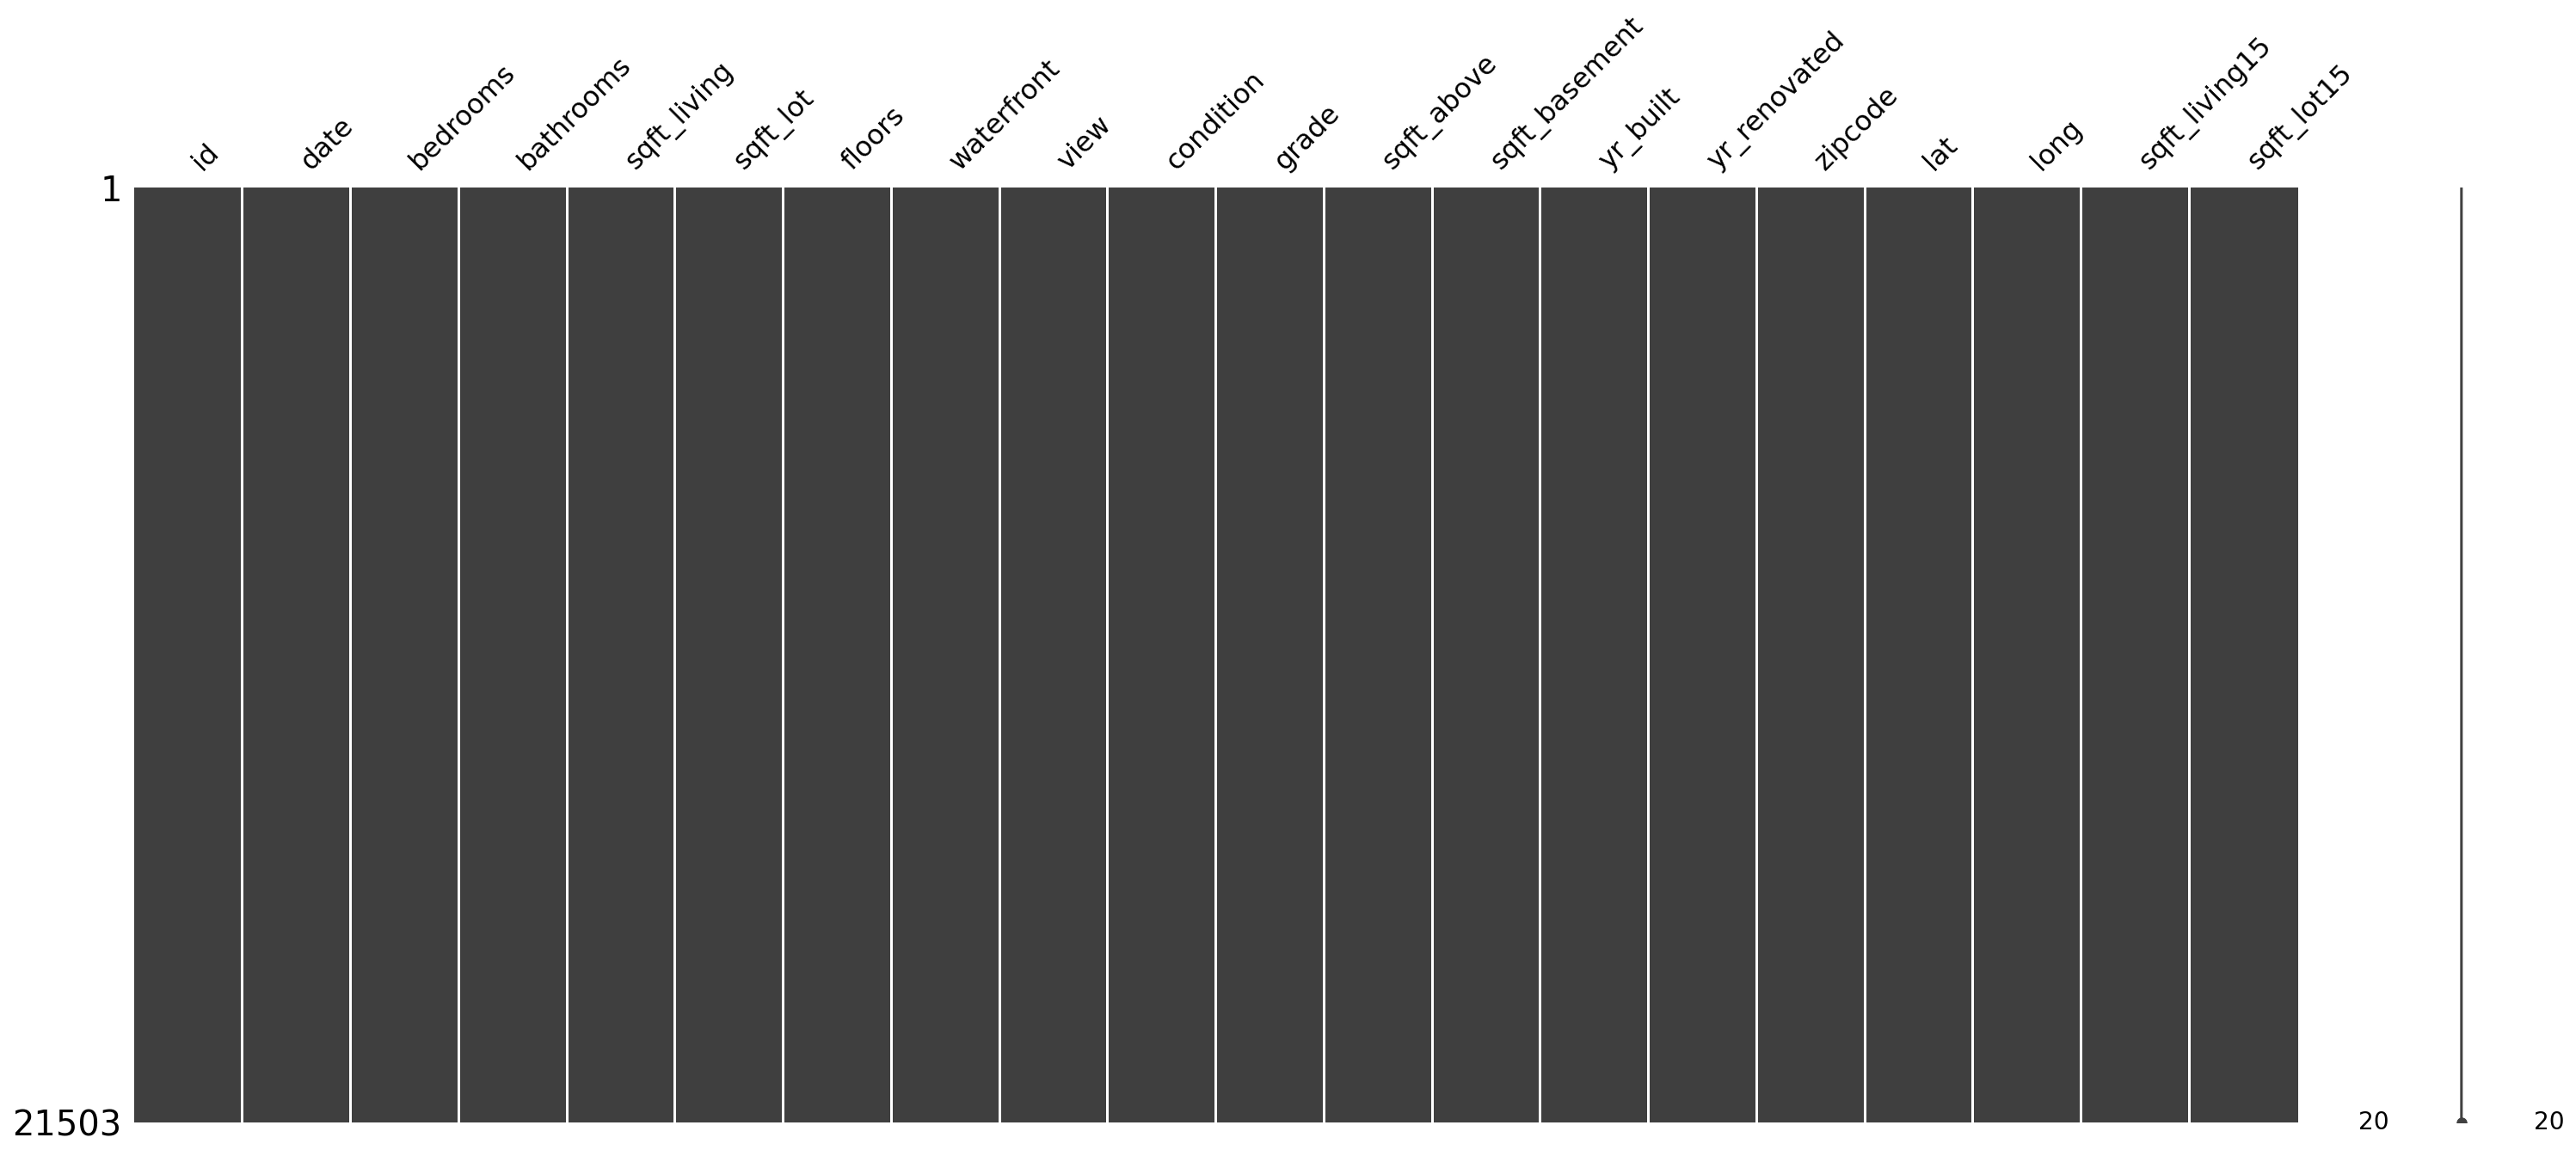

In [9]:
msno.matrix(data) # -----(1)

(1) `missingno` 라이브러리의 `msno.matrix()`으로 시각화하여 결측치를 알 수 있다.
  - data와 sub을 concat으로 병합시켜줘서 `price`의 값만 결측치가 나타남
  - `info()`를 통하여 결측치를 알 수 있지만 시각화를 통해 정확도를 올릴 수 있을 것 같다.

`id`를 이용해 데이터프레임 인덱싱을 적용해보자.
- [데이터프레임 고급 인덱싱](https://datascienceschool.net/01%20python/04.03%20%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1.html?highlight=%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1)


**총 3단계를 거친다.**
1. `id` column이 결측치인지 확인
2. 결측치인 데이터만 뽑아내기
3. 결측치인 데이터의 개수 세기


#### 1. `id` column이 결측치인지 확인

In [10]:
# 1. id colum이 결측치인지 확인
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


`pd.isnull()`은 True와 False로 이루어진 데이터프레임


#### 2. 인덱싱으로 원하는 값 가져오기

In [11]:
# 2. 결측치 데이터만 뽑아내기
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

결측치가 없어서 빈 데이터프레임 출력

#### 3. 결측치인 데이터의 개수 세기

In [12]:
# 3. 결측치 데이터의 개수 세기
print(f'id: {len(null_data.values)}')

id: 0


한번에 작성해보자.

In [13]:
print('{}: {}'.format('id', len(data.loc[pd.isnull(data['id']),'id'])))

id: 0


`id` 이외에 다른 columeh 결측값을 확인하기 위해 for문을 사용해보자.

In [14]:
for c in data.columns:
  print('{}: {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))
  

id: 0
date: 0
bedrooms: 0
bathrooms: 0
sqft_living: 0
sqft_lot: 0
floors: 0
waterfront: 0
view: 0
condition: 0
grade: 0
sqft_above: 0
sqft_basement: 0
yr_built: 0
yr_renovated: 0
zipcode: 0
lat: 0
long: 0
sqft_living15: 0
sqft_lot15: 0


**✓ id, date 변수 정리**


- 필요 없는 `id 컬럼 제거
- 예측 결과 제출을 대비하여 `sub_id`변수에 `id` 칼럼을 저장하고 지우기

In [15]:
sub_id = data['id'][train_len:]
del data['id']
print(len(data.columns))
print(data.columns)

19
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- date column은 apply 함수로 필요한 부분만 잘라준다.
- [Pandas Lambda, apply를 활용하여 복잡한 로직 적용하기](https://data-newbie.tistory.com/207)

In [16]:
data['date'] = data['date'].apply(lambda x : str(x[:6])) # -----(1)
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### Lambda와 apply 활용 살펴보자.
음... 복잡한 로직을 처리할때라는데
```
def slicing_date(x):
  date = str(x[:6])
  return date
print(slicing_date('2014100000000'))
>>> 201410
```
위에 코드는 함수로 기이이일게 나타낸 것이다.   
이것을 lambda로 표현하면 엄청 간결하게 나타낼 수 있다.
```
# lambda 매개변수 : 표현식
lambda x : str(x[:6])
```
와우!! 너무나도 짧다!!


**✓ 각 변수들의 분포 확인**


전체 데이터들의 분포를 확인해보자.   
너무 치우친 분포를 가지는 column의 경우 모델이 결과를 예측하는 데에 않좋은 영향을 미치니 다듬는 작업을 하자.   


이번 작업의 그래프 종류는 `sns.kdeplot`을 사용
  - `kdeplot 은 이산(discrete)데이터의 경우에도 부드러운 곡선으로 전체 분포 확인가능한 시각화 함수
  - [seaborn.kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html)

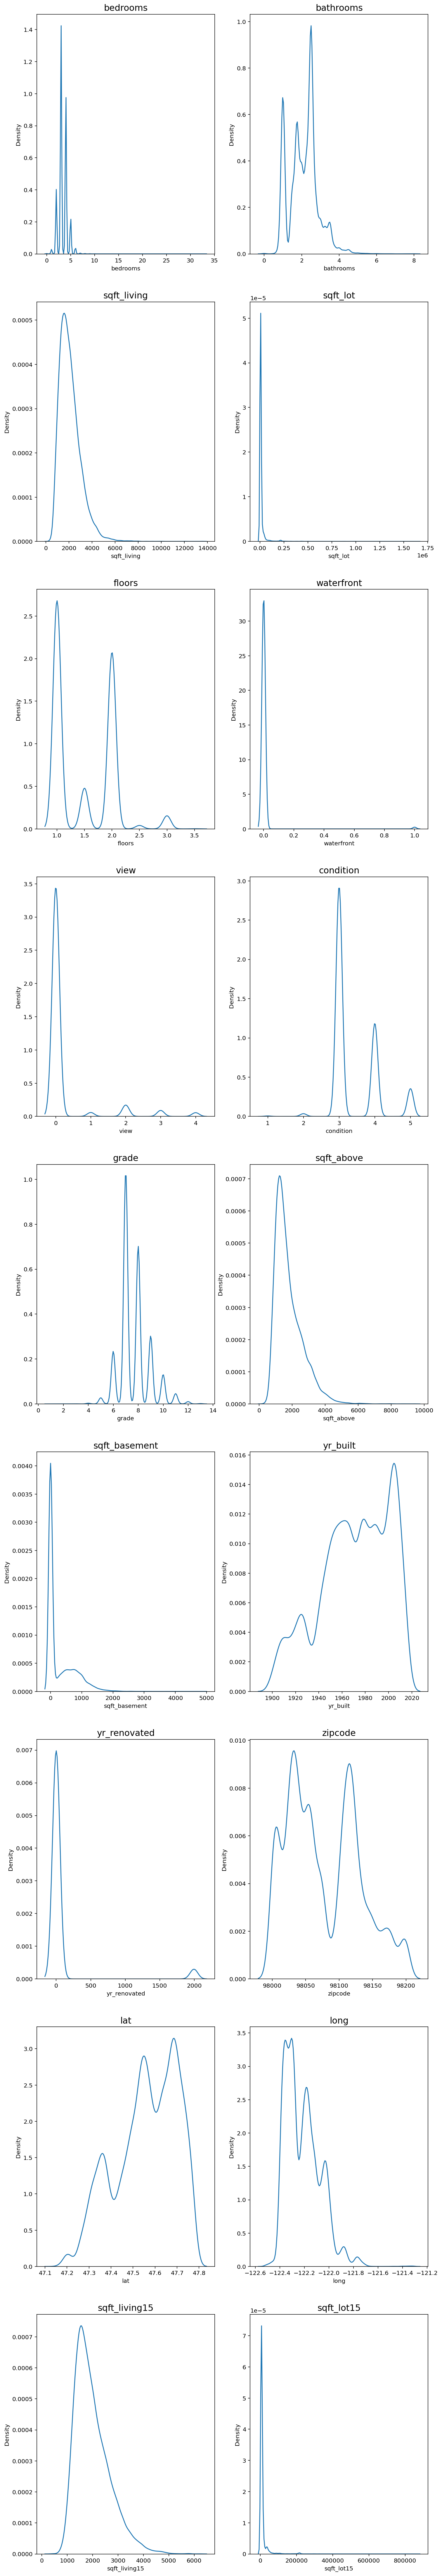

In [17]:
fig, ax = plt.subplots(9, 2, figsize=(12, 80))

# id 변수(count==0인 경우)는 제외하고 분포를 확인
count = 1 # -----(1)
columns = data.columns # -----(2)
for row in range(9): # -----(3)
  for col in range(2): # -----(4)
    sns.kdeplot(data=data[columns[count]], ax=ax[row][col]) # -----(5)
    ax[row][col].set_title(columns[count], fontsize=15) # -----(6)
    count+=1 # -----(7)
    if count == 19: # -----(8)
      break

`ìd`를 지웠으므로 count는 1부터 시작    
(1) 열(column)을 하나씩 출력해주기 위해 기본 값 1로 설정.  
(2) DataFrame으로 저장된 column의 데이터를 columns 변수로 저장.  
(3) 반복문으로 세로 9칸.  
(4) 반복문으로 가로 2칸.  
(5) `sns.kdeplot()`을 이용하여 data는 columns, axis(축)이름은 row, col.  
(6) axis(row, col)의 타이틀은 columns으로 하고 폰트 15.  
(7) count를 1씩 증가하여 다음 column data로 넘겨줌.  
(8) 카운트에 도달하면 끝.  


위 그래프 중에서 `bedrooms`, `sqft_living`, `sqft_lot`, `sqft_above`,   
`sqft_basement`, `sqft_living15`, `sqft_lot15` 변수가 한쪽으로 치우친 경향을 보인다.
  - 로그 변환(log-scaling)을 통해 데이터를 정규분포에 가깝게 만들어주자

- 왼쪽으로 치우친 컬럼들을 `skew_columns` 리스트에 넣고 `np.log1p()`를 이용해 변환
  - `numpy.log1p()` 함수는 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수

In [18]:
print(data[columns])
print(data[columns[1]])

        date  bedrooms  bathrooms  ...     long  sqft_living15  sqft_lot15
0     201410         3       1.00  ... -122.257           1340        5650
1     201502         2       1.00  ... -122.233           2720        8062
2     201502         3       2.00  ... -122.045           1800        7503
3     201406         3       2.25  ... -122.327           2238        6819
4     201501         3       1.50  ... -122.315           1650        9711
...      ...       ...        ...  ...      ...            ...         ...
6463  201406         3       1.75  ... -122.002           1320       11303
6464  201501         3       2.00  ... -122.288           1400        1230
6465  201502         3       2.50  ... -122.409           1330        1265
6466  201406         2       0.75  ... -122.299           1020        2007
6467  201501         3       2.50  ... -122.069           1410        1287

[21503 rows x 19 columns]
0       3
1       2
2       3
3       3
4       3
       ..
6463    3
646

In [19]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', # -----(1)
'sqft_basement', 'sqft_living15', 'sqft_lot15']

for c in skew_columns: # -----(2)
  data[c] = np.log1p(data[c].values)

(1) 변수 `skew_cloumns`에 한쪽으로 치우쳐있는 항목들을 저장   
(2) for문으로 로그화
- 변환된 것을 다시 확인해보자.

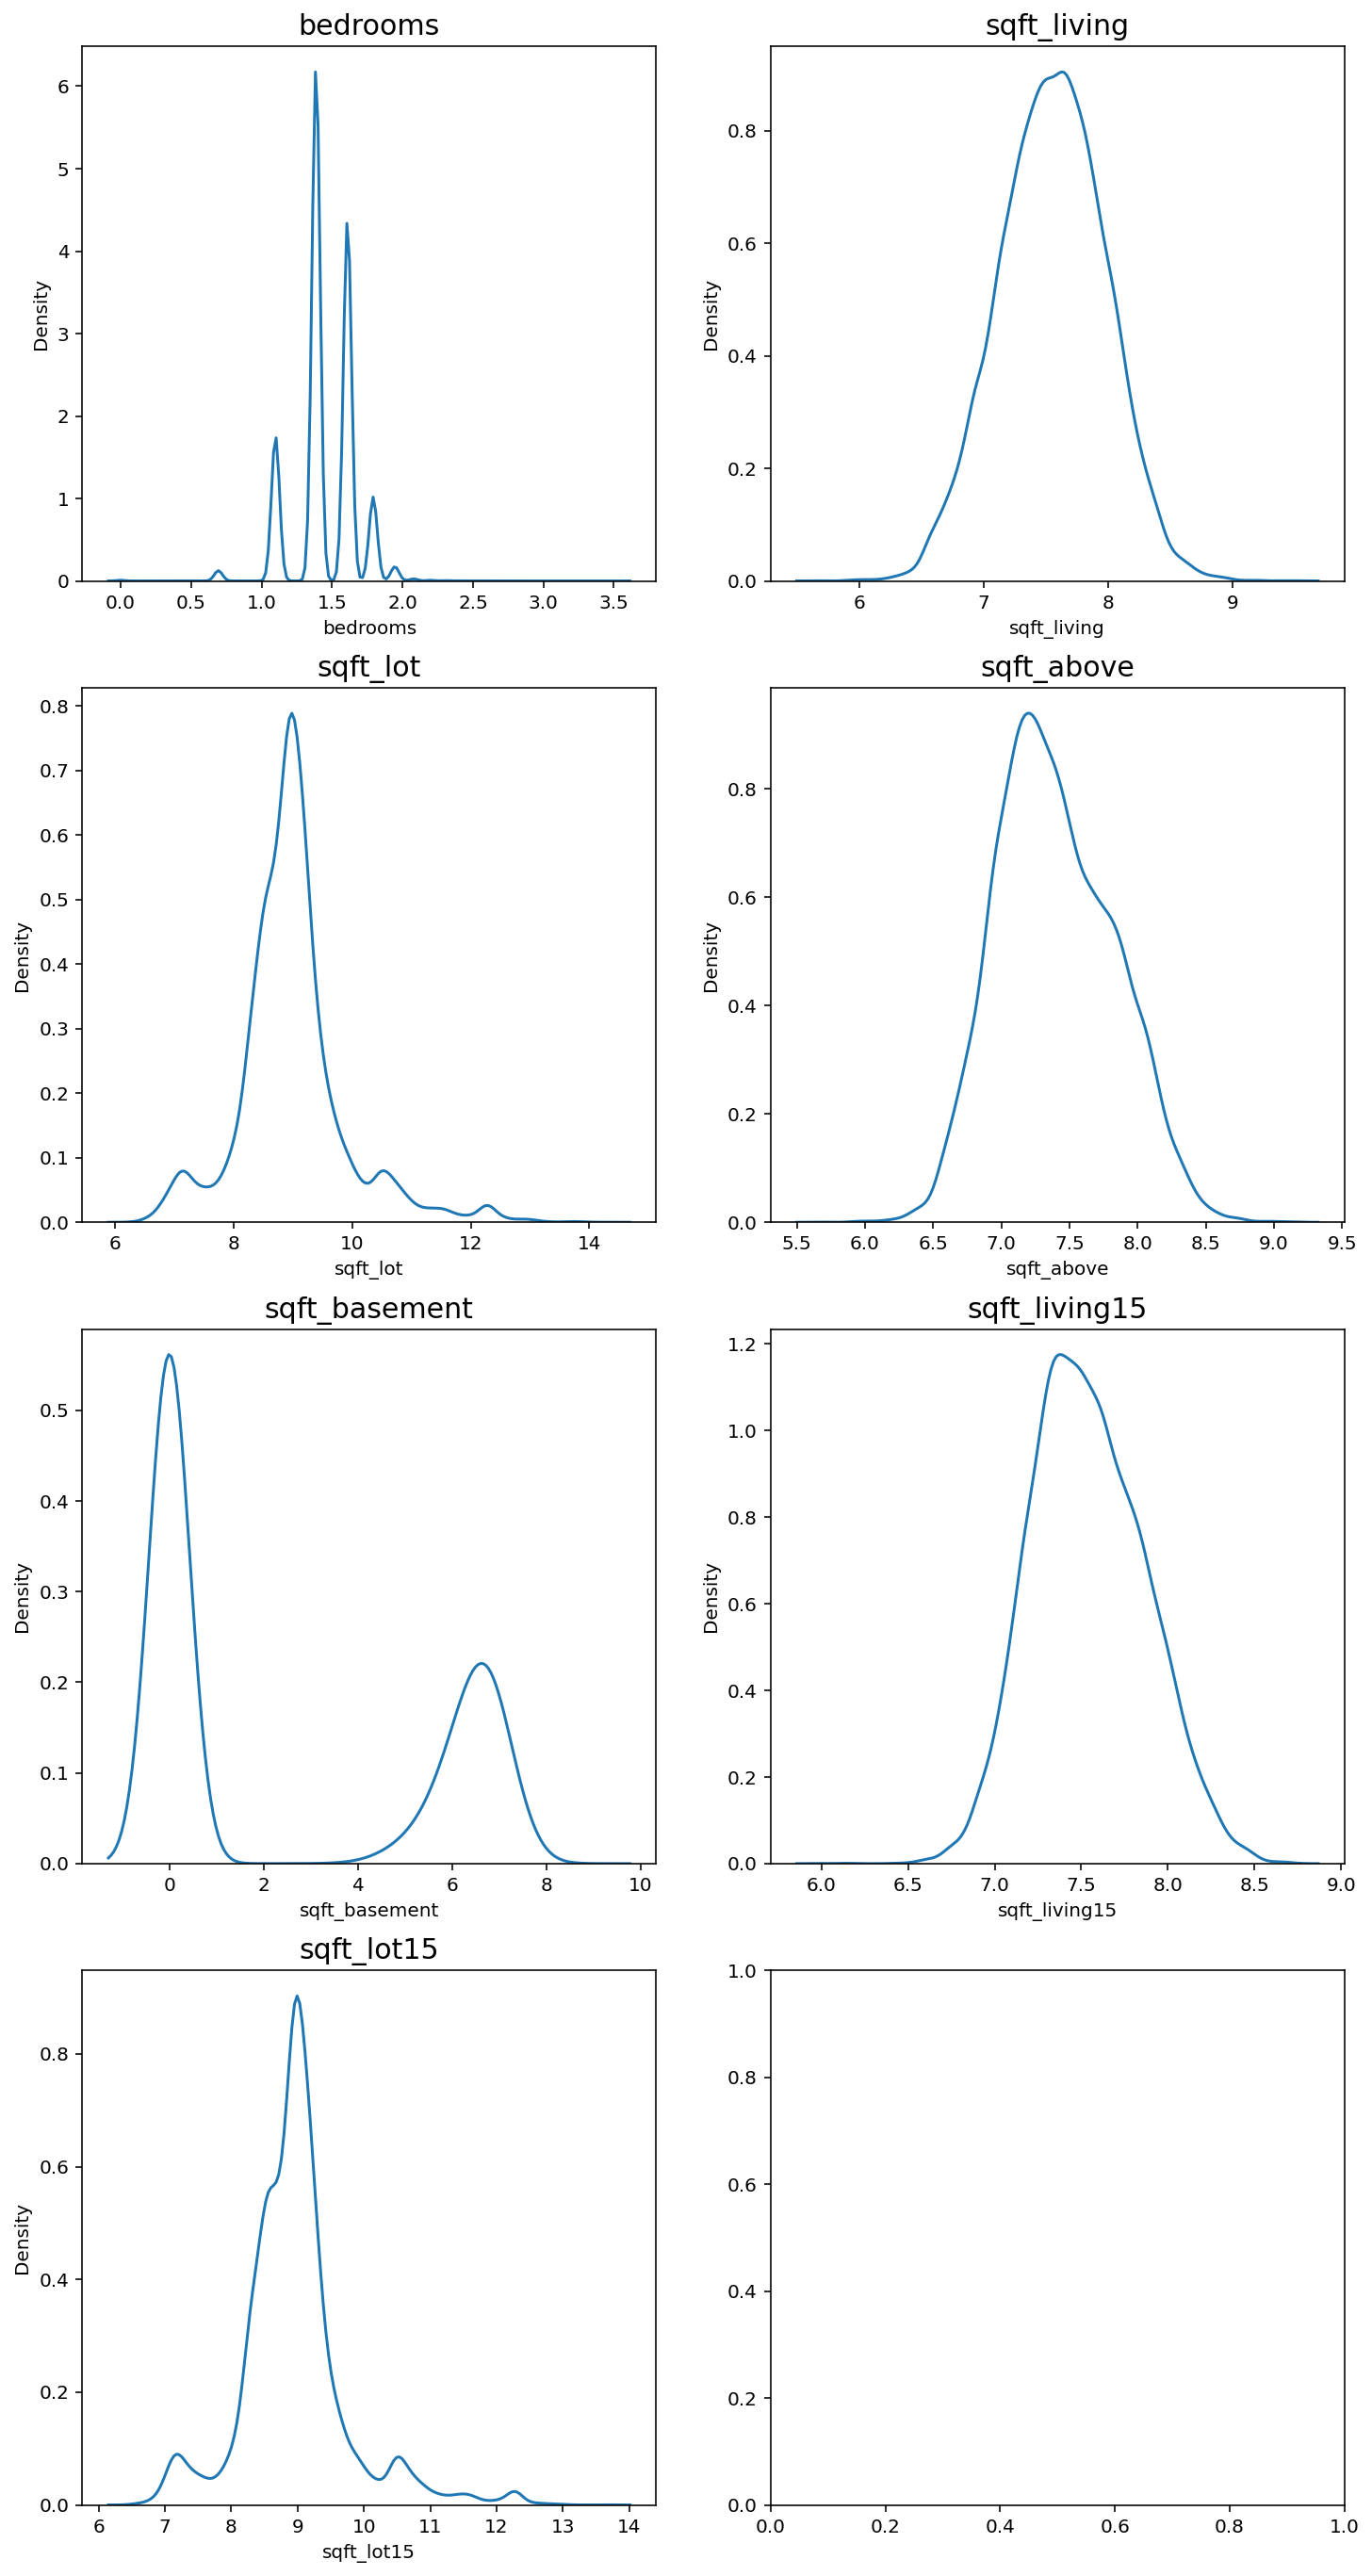

In [20]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

이전보다 치우침이 줄어든 분포를 알 수 있다.   


**그렇다면 왜??? 로그 변환은 분포의 치우침을 줄어들게 만들까??**

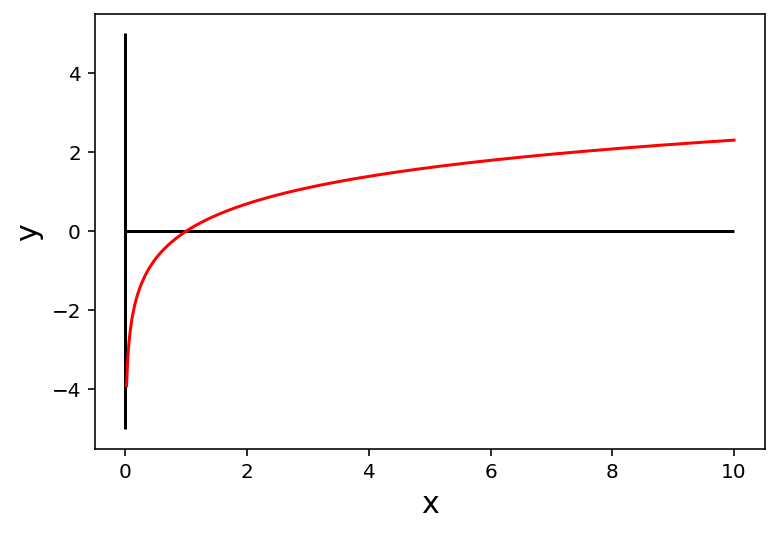

In [21]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.plot(xx, yy, c='r')
plt.show()

- 0 < x < 1 범위의 기울기가 매우 가파름
  - x 구간은(0, 1)로 매우 짧고
  - y 구간은(−∞,0)로 매우 크다
- 0에 가깝게 모여있는 값들이 x로 입력되면, 함수값인 y값은 매우 큰 번위로 벌어진다
- x값이 점점 커지면 로그 함수의 기울기는 급격히 작아진다.
  - 큰 x값들에 대해서는 y값이 크게 차이나지 않는다
  - 넓은 범위를 가지는 x를 비교적 작은 y값의 구간내에 모이게 하는 특징을 가짐


**`data[price]`를 로그 변환으로 확인해보자.**

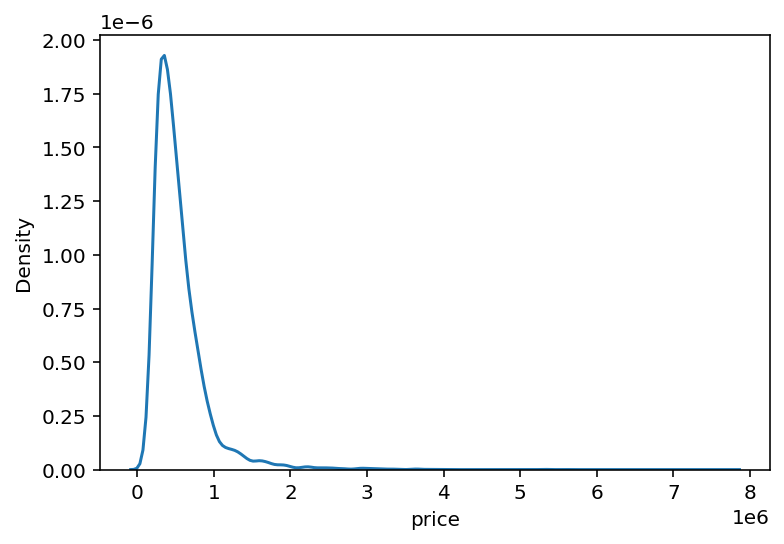

In [22]:
# 기존 price 분포
sns.kdeplot(y)
plt.show()

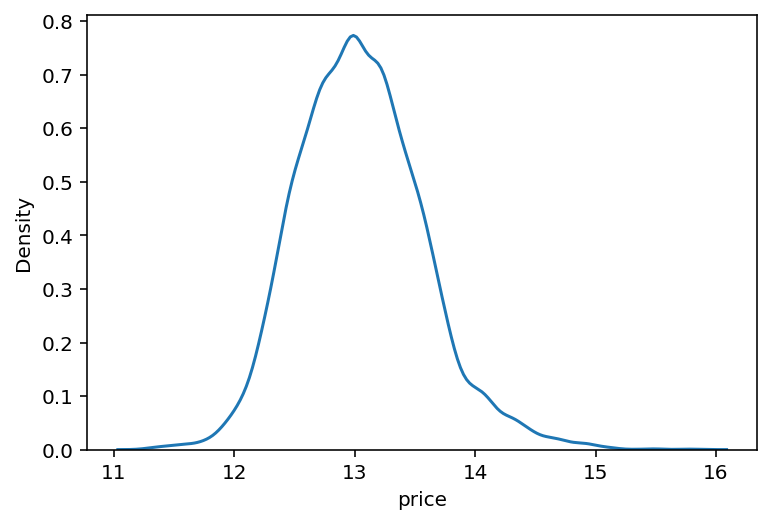

In [23]:
# price를 로그 변환
y_log_transformation = np.log1p(y)
sns.kdeplot(y_log_transformation)
plt.show()

**가운데로 이쁘게 정규분포가 되었다.** 


이제 로그 변환이 필요한 데이터를 처리하였으니, `concat()`으로 묶은 전체 데이터를 다시 나누어주자.

In [24]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(f'1. train_len      : {train_len}')
print(f'2. 학습 데이터 x  : {x.shape}')
print(f'3. 추론 데이터 sub: {sub.shape}')

1. train_len      : 15035
2. 학습 데이터 x  : (15035, 19)
3. 추론 데이터 sub: (6468, 19)


**iloc 인덱서**
순서를 나타내는 정수(integer) 인덱스만 받는다.

In [25]:
df = pd.DataFrame(np.arange(10, 22).reshape(3, 4),
                  index=['a', 'b', 'c'],
                  columns=['A', 'B', 'C', 'D'])
print(df,'\n')
print(df.iloc[0, 1],'\n')
print(df.iloc[:2, 2],'\n')
print(df.iloc[0, -2:],'\n')
print(df.iloc[2:3, 1:3],'\n')

    A   B   C   D
a  10  11  12  13
b  14  15  16  17
c  18  19  20  21 

11 

a    12
b    16
Name: C, dtype: int64 

C    12
D    13
Name: a, dtype: int64 

    B   C
c  19  20 



- 위에 저장한 `train_len`을 인덱스로 활용하여 `:train_len`까지는 학습 데이터를 `x`에 저장
- `train_len:` 부터는 실제 추론해야할 테스트 데이터를 `sub`에 저장

### 2-4. 모델 설계


**✓ 모델링**
Baseline 커널에서는 여러 가지 모델을 함께 사용해서 결과를 섞는 것을 **블렌딩(blending)** 기법을 활용한다.   
> **블렌딩**   
하나의 개별 모델을 사용하는 것이 아닌 다양한 여러 모델을 종합하여 결과는 얻는 기법   
블렌딩=앙상블 기법이라고도 한다.


- [Part1. Introduction to Ensemble Learning](https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.)


> **앙상블이란 무엇이고, 어떤 아이디어부터 착안된 기법인가?**   
앙상블(Ensemble) 학습은 여러 개의 학습 알고리즘을 사용하고, 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법   
하나의 강한 머신러닝 알고리즘보다 여러 개의 약한 머신러닝 알고리즘이 낫다는 아이디어로부터 시작


>  **앙상블 기법 중 기본적인 것은 보팅(Voting)과 에버리징(Averaging)이다. 무엇이고 언제 쓰이나?**   
1. 모두 서로 다른 알고리즘을 가진 분류기를 결합하는 방식
2. Voting은 여러 모델이 분류해 낸 결과들로부터 다수결 투표를 통해 최종 결과를 선택하는 방법으로 분류 문제에 사용
3.  Averaging은 각 모델이 계산한 실수값들을 평균 또는 가중평균하여 사용하는 방법으로 회귀 문제에 사용


- [Kaggle Ensemble Guide](olab.research.google.com/drive/1OEsQkmjXXAevrGdi4RuQ9Gv4y1EDElGz#scrollTo=b_clVWF8sOKg)


> **각각 성능이 70%인 다섯 개의 분류기의 정확도는?**   
0.3087 + 0.3602 + 0.1681 = 0.837, 83.7%

**✓ Average Blending**


여러 가지 모델의 결과를 산술평균하여 블렌딩 모델을 만들어보자.   
모델은 부스팅 계열인 `gboost`, `xgboost`, `lightgbm` 세 가지를 사용

In [26]:
# ! pip install ensemble
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb

gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(objective='reg:squarederror', random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'},
          {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

**✓ Cross Validation**


교차 검증을 통해 모델의 성능 평가


In [27]:
from sklearn.model_selection import KFold, cross_val_score

def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [28]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8624
Model: LightGBM, CV score:0.8819


- `cross_val_score()` 함수는 회귀모델을 전달할 경우 R^2 점수를 반환한다.
- R^2 값은 1에 가까울수록 학습이 잘되었다.
- [결정계수 R squard](https://ltlkodae.tistory.com/19)

**✓ Make Submission File**


- 3개의 트리 모델 결과값
  - Model: GradientBoosting, CV score:0.8598
  - Model: XGBoost, CV score:0.8624
  - Model: LightGBM, CV score:0.8819


Baseline 모델에서는 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내는   
`AveragingBlending()`함수를 만들어 사용한다.
 - `AveragingBlending()`함수는 `models` 딕셔너리 안에 있는 모델을 `x` 와 `y`로 학습시킨 뒤   
 `predictions에` 예측 결과값을 모아서 평균한 값을 반환.


In [29]:
def AveragingBlending(models, x, y, sub_x):
  for m in models:
    # x = data.iloc[:train_len, :]
    # y = data['price']
    m['model'].fit(x.values, y)

  predictions = np.column_stack([
    m['model'].predict(sub_x.values) for m in models
  ])
  return np.mean(predictions, axis=1)

In [30]:
# 함수를 활용해서 예측값을 생성해보자
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 562566.39221578,  389660.68147617, 1340643.45409443, ...,
        438058.69137012,  345498.01852609,  414241.23776683])

In [31]:
# 캐글에서 공유한 샘플 데이터 확인
data_dir = '/content/gdrive/MyDrive/AIFFEL/kaggle-kakr-housing-data/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [32]:
# id 와 prie 두 가지 열로 구성
# 구성된 데이터 프레임 만들기
result = pd.DataFrame({
    'id':sub_id,
    'price':y_pred
})

result.head()

,id,price
0,15035,5.625664e+05
1,15036,3.896607e+05
2,15037,1.340643e+06
3,15038,3.317573e+05
4,15039,2.966855e+05


In [33]:
# 파일 저장!
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/content/gdrive/MyDrive/AIFFEL/kaggle-kakr-housing-data/data/submission.csv
